In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float
Base = declarative_base()

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)
inspector = inspect(engine)

In [6]:
inspector.get_table_names()

['measurement', 'station', 'stations']

In [7]:
columns = inspector.get_columns('measurement')
# columns = inspector.get_columns('station')
# columns = inspector.get_columns('stations')

In [8]:
columns = inspector.get_columns('measurement')
# columns = inspector.get_columns('station')
# columns = inspector.get_columns('stations')
for column in columns:
    print(column['name'],column['type'],column['nullable'],['primary_key'])
#     print(column)

id INTEGER False ['primary_key']
station TEXT True ['primary_key']
date TEXT True ['primary_key']
prcp FLOAT True ['primary_key']
tobs FLOAT True ['primary_key']


In [9]:
engine.execute('SELECT * FROM measurement LIMIT 2').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0)]

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [23]:
Base.classes.keys()

['measurement', 'station', 'stations']

In [22]:
# We can view all of the classes that automap found   --  this has been done with inspector.get tables above
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None), 'stations': Table('stations', MetaData(bind=None), Column('station', VARCHAR(), table=<stations>, primary_key=True, nullable=False), Column('date', VARCHAR(), table=<stations>), Column('prcp', INTEGER(), table=<stations>), Column('tobs', INTEGER(), table=<stations>), schema=None)})

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
Stations = Base.classes.stations

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [24]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f9afa3bd630>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'id': 1,
 'prcp': 0.08}

# Exploratory Climate Analysis

Text(0.5, 1.0, 'Precipitation Last 12 Months')

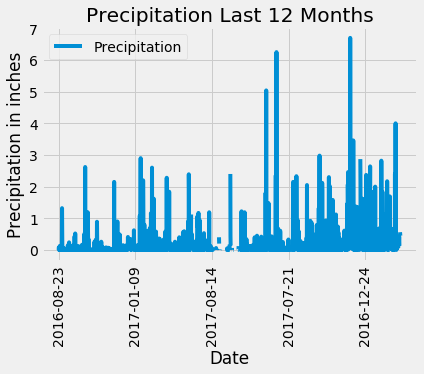

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print ("The last date in the data: ", last_date)

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23)-dt.timedelta(days=365)
# print("One year ago Query date: ", one_year_ago)

# Perform a query to retrieve the date and precipitation scores for the last year of data
rain_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=one_year_ago).all()
rain_scores
# Save the query results as a Pandas DataFrame and set the index to the date column
df =pd.DataFrame(rain_scores,columns=['Date','Precipitation'])
df.head()

# Sort the dataframe by date
df.set_index(df['Date'],inplace=True)
df.sort_index()
# df.head()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation in inches')
plt.title("Precipitation Last 12 Months")


In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [54]:
# Design a query to show how many stations are available in this dataset?
station_count =session.query(func.count(Station.station)).all()
station_count[0]

(9)

In [55]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations= session.query(Measurement.station, func.count(Measurement.station)).\
                              group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest func.min(Measurement.tobs)

In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
